In [ ]:
import torch
import gc 


torch.cuda.empty_cache()  
gc.collect()              

0

In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("Device Count:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU Only")
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No CUDA Device")

CUDA Available: False
Device Count: 0
Current Device: CPU Only
Device Name: No CUDA Device


In [16]:
!ls /kaggle/input/busi-final/archive/Dataset_BUSI_with_GT


benign	malignant  normal


In [ ]:
import os
import shutil
import random
import numpy as np
from sklearn.model_selection import train_test_split

DATASET_PATH = r"C:\Users\chitr\OneDrive\Desktop\FINAL\NEw\BUSI\Dataset_BUSI_with_GT"  
OUTPUT_PATH = "/kaggle/working/output" 

CATEGORIES = ["normal", "benign", "malignant"]

for split in ["train", "test"]:
    for category in CATEGORIES:
        os.makedirs(os.path.join(OUTPUT_PATH, split, category), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_PATH, split, f"{category}_masks"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, "missing_masks"), exist_ok=True) 

image_data = {category: [] for category in CATEGORIES}
missing_masks = []

for category in CATEGORIES:
    category_path = os.path.join(DATASET_PATH, category)
    if not os.path.exists(category_path):
        raise FileNotFoundError(f"Dataset path {category_path} not found!")

    images = sorted([f for f in os.listdir(category_path) if f.endswith((".png", ".jpg")) and "_mask" not in f])

    for img in images:
        img_path = os.path.join(category_path, img) 
        mask_path_png = os.path.join(category_path, img.rsplit(".", 1)[0] + "_mask.png")
        mask_path_jpg = os.path.join(category_path, img.rsplit(".", 1)[0] + "_mask.jpg")
        mask_path = mask_path_png if os.path.exists(mask_path_png) else mask_path_jpg if os.path.exists(mask_path_jpg) else None
        
        if mask_path:
            image_data[category].append((img_path, mask_path))
        else:
            missing_masks.append(img_path)  

train_data, test_data = {}, {}

for category in CATEGORIES:
    train_imgs, test_imgs = train_test_split(
        image_data[category], test_size=0.2, random_state=42, stratify=[category] * len(image_data[category])
    )
    train_data[category] = train_imgs
    test_data[category] = test_imgs

def move_files(data, split):
    for category, img_list in data.items():
        for img_path, mask_path in img_list:
            img_filename = os.path.basename(img_path)
            mask_filename = os.path.basename(mask_path)

            dest_img = os.path.join(OUTPUT_PATH, split, category, img_filename)
            dest_mask = os.path.join(OUTPUT_PATH, split, f"{category}_masks", mask_filename)

            shutil.copy2(img_path, dest_img)
            shutil.copy2(mask_path, dest_mask)

move_files(train_data, "train")
move_files(test_data, "test")

for img_path in missing_masks:
    shutil.copy2(img_path, os.path.join(OUTPUT_PATH, "missing_masks", os.path.basename(img_path)))

print("\n✅ Dataset preparation completed successfully!")
for category in CATEGORIES:
    print(f"📊 {category.upper()}:")
    print(f"   - Train: {len(train_data[category])} images")
    print(f"   - Test: {len(test_data[category])} images")
print(f"\n⚠️ {len(missing_masks)} images found without masks. Saved in 'missing_masks' folder.")



✅ Dataset preparation completed successfully!
📊 NORMAL:
   - Train: 106 images
   - Test: 27 images
📊 BENIGN:
   - Train: 349 images
   - Test: 88 images
📊 MALIGNANT:
   - Train: 168 images
   - Test: 42 images

⚠️ 0 images found without masks. Saved in 'missing_masks' folder.


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm


INPUT_PATH = "/kaggle/working/output"
OUTPUT_PATH = "/kaggle/working/preprocessed_output"

CATEGORIES = ["normal", "benign", "malignant"]


for split in ["train", "test"]:  
    for category in CATEGORIES:
        os.makedirs(os.path.join(OUTPUT_PATH, split, category), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_PATH, split, f"{category}_masks"), exist_ok=True)

def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)  
    if image is None:
        print(f"⚠️ Warning: Could not read {image_path}")
        return None

   
    if len(image.shape) == 3:  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    enhanced = clahe.apply(image)
    resized = cv2.resize(enhanced, (224, 224))

    return resized

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask is None:
        print(f"⚠️ Warning: Could not read mask {mask_path}")
        return None

    resized_mask = cv2.resize(mask, (224, 224), interpolation=cv2.INTER_NEAREST)

    _, binary_mask = cv2.threshold(resized_mask, 127, 255, cv2.THRESH_BINARY)

    return binary_mask

for split in ["train", "test"]:
    for category in CATEGORIES:
        input_folder = os.path.join(INPUT_PATH, split, category)
        output_folder = os.path.join(OUTPUT_PATH, split, category)

        if not os.path.exists(input_folder) or not os.listdir(input_folder):
            print(f"⚠️ Warning: No images found in {input_folder}, skipping...")
            continue

        image_files = [f for f in os.scandir(input_folder) if f.is_file() and f.name.endswith((".png", ".jpg"))]
        
        for file in tqdm(image_files, desc=f"Processing {split}/{category}"):
            img_path = file.path
            preprocessed_img = preprocess_image(img_path)

            if preprocessed_img is not None:
                output_img_path = os.path.join(output_folder, file.name)
                cv2.imwrite(output_img_path, preprocessed_img)
for split in ["train", "test"]:
    for category in CATEGORIES:
        mask_input_folder = os.path.join(INPUT_PATH, split, f"{category}_masks")
        mask_output_folder = os.path.join(OUTPUT_PATH, split, f"{category}_masks")

        if not os.path.exists(mask_input_folder) or not os.listdir(mask_input_folder):
            print(f"⚠️ Warning: No masks found in {mask_input_folder}, skipping...")
            continue

        mask_files = [f for f in os.scandir(mask_input_folder) if f.is_file() and f.name.endswith((".png", ".jpg"))]

        for file in tqdm(mask_files, desc=f"Processing masks for {split}/{category}"):
            mask_path = file.path
            preprocessed_mask = preprocess_mask(mask_path)

            if preprocessed_mask is not None:
                output_mask_path = os.path.join(mask_output_folder, file.name)
                cv2.imwrite(output_mask_path, preprocessed_mask)

print("✅ ROI-Free Preprocessing Completed Successfully!")

Processing masks for test/malignant: 100%|██████████| 42/42 [00:00<00:00, 146.48it/s]

✅ ROI-Free Preprocessing Completed Successfully!


📏 Original Image Size: (471, 554)
📏 Preprocessed Image Size: (224, 224)


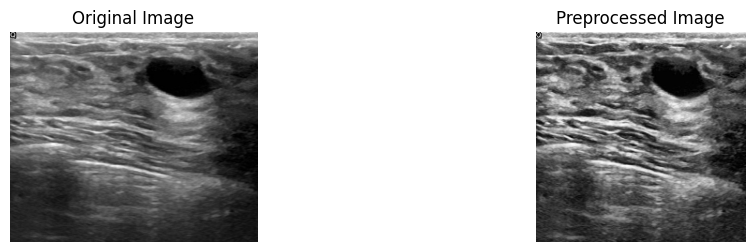

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2
import os

def display_images_and_masks(image_path, preprocessed_path, mask_path=None, preprocessed_mask_path=None):

    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    preprocessed_img = cv2.imread(preprocessed_path, cv2.IMREAD_GRAYSCALE)

    if original_img is None or preprocessed_img is None:
        print(f"⚠️ Error loading images: {image_path}, {preprocessed_path}")
        return

    print(f"📏 Original Image Size: {original_img.shape}")
    print(f"📏 Preprocessed Image Size: {preprocessed_img.shape}")


    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.imshow(original_img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(preprocessed_img, cmap="gray")
    plt.title("Preprocessed Image")
    plt.axis("off")

    if mask_path and preprocessed_mask_path:
        original_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        preprocessed_mask = cv2.imread(preprocessed_mask_path, cv2.IMREAD_GRAYSCALE)

        if original_mask is not None and preprocessed_mask is not None:
            print(f"📏 Original Mask Size: {original_mask.shape}")
            print(f"📏 Preprocessed Mask Size: {preprocessed_mask.shape}")

            plt.subplot(2, 2, 3)
            plt.imshow(original_mask, cmap="gray")
            plt.title("Original Mask")
            plt.axis("off")

            plt.subplot(2, 2, 4)
            plt.imshow(preprocessed_mask, cmap="gray")
            plt.title("Preprocessed Mask")
            plt.axis("off")

    plt.show()

test_category = "benign" 
test_folder = os.path.join(OUTPUT_PATH, "test", test_category)
test_mask_folder = os.path.join(OUTPUT_PATH, "test", f"{test_category}_masks")

test_images = [f for f in os.listdir(test_folder) if f.endswith((".png", ".jpg"))]

if test_images:
    random_image = random.choice(test_images)
    original_path = os.path.join(INPUT_PATH, "test", test_category, random_image)
    preprocessed_path = os.path.join(test_folder, random_image)

    original_mask_path = os.path.join(INPUT_PATH, "test", f"{test_category}_masks", random_image)
    preprocessed_mask_path = os.path.join(test_mask_folder, random_image)

    display_images_and_masks(original_path, preprocessed_path, original_mask_path, preprocessed_mask_path)
else:
    print(f"⚠️ No test images found in {test_folder}")


In [ ]:
import torch
import torch.nn as nn
from torch.nn.init import trunc_normal_

class DropPath(nn.Module):
    def __init__(self, drop_prob=0.):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
        random_tensor.floor_()
        return x.div(keep_prob) * random_tensor

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=False)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class HoVerTransBlock(nn.Module):
    def __init__(self, in_channels, embed_dim, num_heads=4, drop_path_rate=0.1):
        super(HoVerTransBlock, self).__init__()
        self.horizontal_branch = nn.Conv2d(in_channels, embed_dim, kernel_size=(1, 3), padding=(0, 1))
        self.vertical_branch = nn.Conv2d(in_channels, embed_dim, kernel_size=(3, 1), padding=(1, 0))
        
        self.norm = nn.BatchNorm2d(embed_dim)
        self.activation = nn.ReLU(inplace=True)
        
        self.attn = Attention(embed_dim, num_heads)
        self.drop_path = DropPath(drop_path_rate)
        
        self.fusion = nn.Conv2d(embed_dim * 2, embed_dim, kernel_size=1)

    def forward(self, x):
        h = self.activation(self.norm(self.horizontal_branch(x)))
        v = self.activation(self.norm(self.vertical_branch(x)))
        
        fused = torch.cat([h, v], dim=1)
        fused = self.activation(self.norm(self.fusion(fused)))
        
        B, C, H, W = fused.shape
        fused = fused.flatten(2).permute(0, 2, 1)  
        fused = self.attn(fused)
        fused = fused.permute(0, 2, 1).reshape(B, C, H, W) 
        
        fused = self.drop_path(fused)
        return fused

class HoVerTrans(nn.Module):
    def __init__(self, num_classes=3):
        super(HoVerTrans, self).__init__()
        self.conv_stem = nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3)
        self.norm1 = nn.BatchNorm2d(8)
        self.activation = nn.ReLU(inplace=True)

        self.stage1 = HoVerTransBlock(8, 16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.stage2 = HoVerTransBlock(16, 32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.stage3 = HoVerTransBlock(32, 64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.stage4 = HoVerTransBlock(64, 128)
        self.pool4 = nn.AdaptiveAvgPool2d((1, 1)) 

        self.fc = nn.Linear(128, num_classes)
        trunc_normal_(self.fc.weight, std=0.02)

    def forward(self, x):
        x = self.activation(self.norm1(self.conv_stem(x)))
        x = self.stage1(x)
        x = self.pool1(x)
        x = self.stage2(x)
        x = self.pool2(x)
        x = self.stage3(x)
        x = self.pool3(x)
        x = self.stage4(x)
        x = self.pool4(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def create_model(**kwargs):
    model = HoVerTrans(**kwargs)
    return model

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class BUSIDataset(Dataset):
    def __init__(self, root_dir, transform=None, include_masks=False):
        self.root_dir = root_dir
        self.transform = transform
        self.include_masks = include_masks
        
        self.image_paths = []
        self.mask_paths = []
        self.labels = []
        
        self.class_map = {"normal": 0, "benign": 1, "malignant": 2}

        for category in self.class_map.keys():
            img_folder = os.path.join(root_dir, category)
            mask_folder = os.path.join(root_dir, category + "_masks")
            
            if not os.path.exists(img_folder):
                print(f"⚠️ Warning: Missing folder {img_folder}, skipping...")
                continue

            for filename in os.listdir(img_folder):
                if filename.endswith((".png", ".jpg"))
                    img_path = os.path.join(img_folder, filename)
                    mask_path = os.path.join(mask_folder, filename) if os.path.exists(mask_folder) else None

                    self.image_paths.append(img_path)
                    self.labels.append(self.class_map[category])
                    
                    if include_masks and mask_path and os.path.exists(mask_path):
                        self.mask_paths.append(mask_path)
                    else:
                        self.mask_paths.append(None)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)

        if self.include_masks:
            mask_path = self.mask_paths[idx]
            if mask_path is not None:
                mask = Image.open(mask_path).convert("L")  
                mask = transforms.ToTensor()(mask)  
            else:
                mask = torch.zeros((1, 224, 224)) 
            
            return image, mask, torch.tensor(label, dtype=torch.long)

        return image, torch.tensor(label, dtype=torch.long)


transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(contrast=0.8),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  
])


train_dataset = BUSIDataset(root_dir="/kaggle/working/preprocessed_output/train", transform=transform_train, include_masks=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


for images, masks, labels in train_loader:
    print(f"Batch Image Shape: {images.shape}")  
    print(f"Batch Mask Shape: {masks.shape}") 
    print(f"Batch Labels: {labels}")
    break 

Batch Image Shape: torch.Size([32, 3, 224, 224])
Batch Mask Shape: torch.Size([32, 1, 224, 224])
Batch Labels: tensor([1, 2, 1, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 1, 1, 2, 2, 1, 1, 1, 1, 0, 1, 1,
        2, 1, 1, 0, 1, 2, 2, 1])


In [ ]:
from torchvision.models.vision_transformer import vit_b_16
import torch
import torch.nn as nn

class ViTEncoder(nn.Module):
    def __init__(self, pretrained=True):
        super(ViTEncoder, self).__init__()
        weights = "IMAGENET1K_V1" if pretrained else None
        self.vit = vit_b_16(weights=weights) 
        self.vit.heads = nn.Identity() 

    def forward(self, x):
        if x.shape[1] == 1:  
            x = x.repeat(1, 3, 1, 1)  

        x = self.vit.conv_proj(x)  
        x = x.flatten(2).transpose(1, 2)  

        batch_size = x.shape[0]
        class_token = self.vit.class_token.expand(batch_size, -1, -1)
        x = torch.cat([class_token, x], dim=1)  

        x = x + self.vit.encoder.pos_embedding[:, :x.shape[1], :].expand(batch_size, -1, -1)
   
        for blk in self.vit.encoder.layers:
            x = blk(x)

        return x[:, 0, :] 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaskedAutoencoder(nn.Module):
    def __init__(self, encoder, mask_ratio=0.75):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = encoder
        self.mask_ratio = mask_ratio
        self.hidden_dim = 768  
        self.num_patches = 196 

        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_dim, 1024),
            nn.LayerNorm(1024),
            nn.ReLU(),
            nn.Linear(1024, self.hidden_dim),
            nn.ReLU(),
        )

        self.patch_to_image = nn.ConvTranspose2d(
            in_channels=self.hidden_dim, out_channels=3, kernel_size=16, stride=16
        )

    def _apply_mask(self, x):
     
        batch_size, num_patches, _ = x.shape
        num_masked = int(self.mask_ratio * num_patches)

        mask_indices = torch.rand(batch_size, num_patches, device=x.device).argsort(dim=1)[:, :num_masked]

        mask = torch.ones(batch_size, num_patches, device=x.device)
        mask.scatter_(1, mask_indices, 0)

        masked_x = x * mask.unsqueeze(-1) 
        return masked_x, mask

    def forward(self, x):
        batch_size = x.shape[0]
    
        x_patches = self.encoder.vit.conv_proj(x)  
        x_patches = x_patches.flatten(2).transpose(1, 2)  

        masked_x, mask = self._apply_mask(x_patches)  
    
        cls_token = self.encoder.vit.class_token.expand(batch_size, -1, -1) 
        masked_x = torch.cat([cls_token, masked_x], dim=1)  
    
        encoded = self.encoder.vit.encoder(masked_x)  
       
        reconstructed_patches = self.decoder(encoded[:, 1:, :])  
  
        reconstructed_patches = reconstructed_patches.transpose(1, 2).reshape(batch_size, self.hidden_dim, 14, 14)
 
        reconstructed_image = self.patch_to_image(reconstructed_patches)
    
        return reconstructed_image, mask

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

class ContrastiveLearning(nn.Module):
    def __init__(self, encoder, queue_size=1024, temperature=0.7, momentum=0.999):
        super(ContrastiveLearning, self).__init__()
        self.encoder_q = encoder 
        self.encoder_k = copy.deepcopy(encoder)  
        self.temperature = temperature
        self.queue_size = queue_size
        self.momentum = momentum

        self.register_buffer("queue", torch.randn(queue_size, 768))
        self.queue = F.normalize(self.queue, dim=1)  


        for param_k in self.encoder_k.parameters():
            param_k.requires_grad = False

    @torch.no_grad()
    def update_momentum_encoder(self):
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = self.momentum * param_k.data + (1 - self.momentum) * param_q.data

    def forward(self, q, k):
        q = F.normalize(q, dim=-1) 
        k = F.normalize(k, dim=-1).detach()
    
        
        logits = torch.mm(q, self.queue.T) / self.temperature 
    
        labels = torch.zeros(q_features.shape[0], dtype=torch.long, device=device)  
    
        self._dequeue_and_enqueue(k)
    
        self.update_momentum_encoder()
    
        return logits, labels


    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        keys = keys.detach()  

        batch_size = keys.shape[0]
        queue_size = self.queue.shape[0]

        if batch_size >= queue_size:
            self.queue = keys[-queue_size:]  
        else:
            self.queue = torch.cat([self.queue[batch_size:], keys], dim=0)  

In [ ]:
import torch
import gc 

torch.cuda.empty_cache()  
gc.collect()               

6414

In [ ]:
import torch
import torch.nn as nn

class ViTClassifier(nn.Module):
    def __init__(self, pretrained_encoder, num_classes=3):
        super(ViTClassifier, self).__init__()
        self.encoder = pretrained_encoder 

        for param in self.encoder.parameters():
            param.requires_grad = False  

        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        features = self.encoder(x)  
        output = self.classifier(features)  
        return output


In [ ]:
import os
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/kaggle/working/vit_encoder.pth"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model file not found: {model_path}. Check the path or re-save the model.")

encoder = ViTEncoder() 
encoder.load_state_dict(torch.load(model_path, map_location=device), strict=False)
encoder.to(device)

with torch.no_grad():
    encoder.eval()

print("✅ ViT Encoder Loaded Successfully!")


<ipython-input-31-c187e971c604>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(model_path, map_location=device), strict=False)


✅ ViT Encoder Loaded Successfully!


In [32]:
classifier_model = ViTClassifier(encoder).to(device)

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import timm
from timm.data.mixup import Mixup
from collections import Counter
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from torchvision.datasets import ImageFolder  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

mixup_fn = Mixup(mixup_alpha=0.4, cutmix_alpha=0.4, prob=0.5, switch_prob=0.5, mode="batch", label_smoothing=0.1, num_classes=3)

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),  
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)), 
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3),
])


class MergedImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        
        self.class_map = {"benign": 0, "malignant": 1, "normal": 2}

        self.targets = []
        new_samples = []
        for path, _ in self.samples:
            folder_name = os.path.basename(os.path.dirname(path))  
            if folder_name in self.class_map:
                label = self.class_map[folder_name]
                self.targets.append(label)
                new_samples.append((path, label))
    
        self.samples = new_samples


train_dataset = MergedImageFolder(root="/kaggle/working/output/train", transform=transform_train)
test_dataset = MergedImageFolder(root="/kaggle/working/output/test", transform=transform_train)


class_counts = Counter(train_dataset.targets)
weights = 1.0 / torch.tensor([max(1, class_counts[i]) for i in train_dataset.targets], dtype=torch.float)
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, drop_last=True)

print("Class Mapping:", train_dataset.class_map)
print("Class Counts:", class_counts)


Using device: cuda
Class Mapping: {'benign': 0, 'malignant': 1, 'normal': 2}
Class Counts: Counter({0: 349, 1: 168, 2: 106})


<ipython-input-39-725b83db1131>:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-39-725b83db1131>:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # ✅ Use AMP for faster training


Epoch 1/100, Loss: 20.8792, Accuracy: 37.66%, LR: 0.000029
Epoch 2/100, Loss: 20.4627, Accuracy: 45.72%, LR: 0.000045
Epoch 3/100, Loss: 19.9958, Accuracy: 53.95%, LR: 0.000013
Epoch 4/100, Loss: 19.4950, Accuracy: 63.49%, LR: 0.000049
Epoch 5/100, Loss: 19.1312, Accuracy: 62.34%, LR: 0.000039
Epoch 6/100, Loss: 18.6310, Accuracy: 65.46%, LR: 0.000022
Epoch 7/100, Loss: 18.2268, Accuracy: 69.41%, LR: 0.000006
Epoch 8/100, Loss: 18.0360, Accuracy: 72.86%, LR: 0.000050
Epoch 9/100, Loss: 17.6695, Accuracy: 70.39%, LR: 0.000048
Epoch 10/100, Loss: 17.3013, Accuracy: 70.56%, LR: 0.000043
Epoch 11/100, Loss: 16.5995, Accuracy: 73.36%, LR: 0.000035
Epoch 12/100, Loss: 16.6240, Accuracy: 70.39%, LR: 0.000026
Epoch 13/100, Loss: 16.0795, Accuracy: 72.86%, LR: 0.000017
Epoch 14/100, Loss: 16.0005, Accuracy: 73.68%, LR: 0.000010
Epoch 15/100, Loss: 16.0813, Accuracy: 71.71%, LR: 0.000004
Epoch 42/100, Loss: 12.3699, Accuracy: 80.43%, LR: 0.000042
Epoch 43/100, Loss: 12.9971, Accuracy: 77.63%, LR

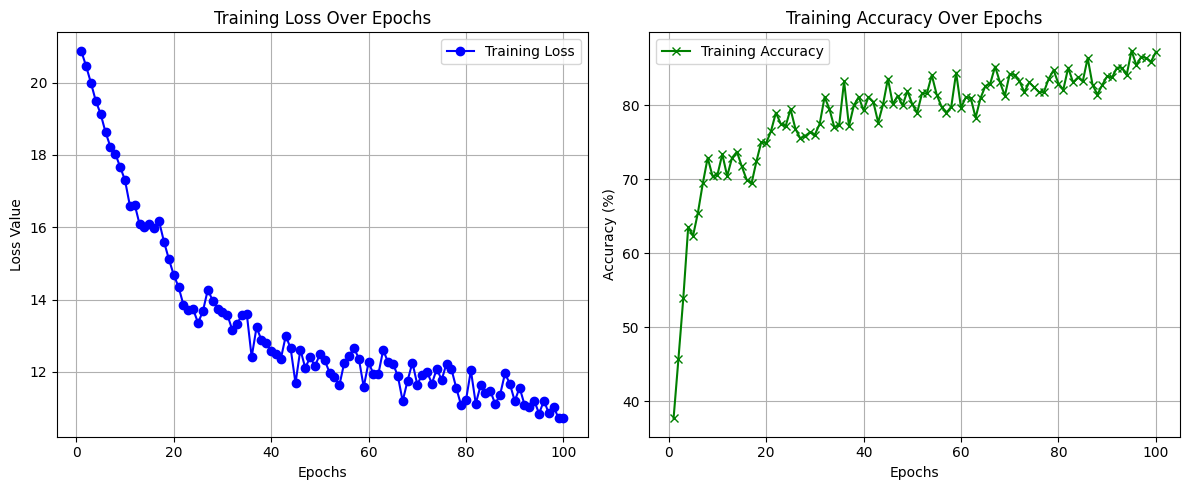

In [ ]:
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler


classifier_model = ViTClassifier(pretrained_encoder=encoder, num_classes=3).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  
optimizer = optim.AdamW(classifier_model.parameters(), lr=5e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)

scaler = GradScaler()

train_losses = []
train_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    classifier_model.train()
    total_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast():  
            outputs = classifier_model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        scheduler.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total * 100

    train_losses.append(total_loss)
    train_accuracies.append(accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}")
torch.save(classifier_model.state_dict(), "/kaggle/working/fine_tuned_vit_classifier.pth")
print("Training Completed! ✅")
plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss", color="blue", linestyle="-", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Training Accuracy", color="green", linestyle="-", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [40]:
# Load the trained model for evaluation
classifier_model.load_state_dict(torch.load("/kaggle/working/fine_tuned_vit_classifier.pth",weights_only=True))
classifier_model.eval()

ViTClassifier(
  (encoder): ViTEncoder(
    (vit): VisionTransformer(
      (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (encoder): Encoder(
        (dropout): Dropout(p=0.0, inplace=False)
        (layers): Sequential(
          (encoder_layer_0): EncoderBlock(
            (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (self_attention): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
            (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): MLPBlock(
              (0): Linear(in_features=768, out_features=3072, bias=True)
              (1): GELU(approximate='none')
              (2): Dropout(p=0.0, inplace=False)
              (3): Linear(in_features=3072, out_features=768, bias=True)
              (4): Dropout(p=0.0, inplace=False)
            )
         

In [ ]:
classifier_model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = classifier_model(images)
        predicted = outputs.softmax(dim=1).argmax(dim=1)

        y_true.extend(labels.cpu().tolist())  
        y_pred.extend(predicted.cpu().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
accuracy = accuracy_score(y_true, y_pred) * 100
precision = precision_score(y_true, y_pred, average="weighted", zero_division=0) * 100
recall = recall_score(y_true, y_pred, average="weighted", zero_division=0) * 100
f1 = f1_score(y_true, y_pred, average="weighted", zero_division=0) * 100
print(f"✅ Model Evaluation Results:")
print(f"🔹 Accuracy: {accuracy:.2f}%")
print(f"🔹 Precision: {precision:.2f}%")
print(f"🔹 Recall: {recall:.2f}%")
print(f"🔹 F1 Score: {f1:.2f}%")

✅ Model Evaluation Results:
🔹 Accuracy: 89.97%
🔹 Precision: 92.23%
🔹 Recall: 89.97%
🔹 F1 Score: 87.56%


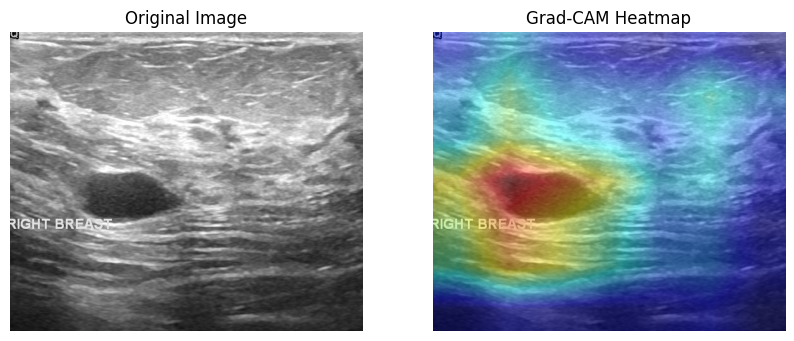

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

def get_last_conv_layer(model):
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, torch.nn.Conv2d):
            return name
    return None

# ✅ Grad-CAM Implementation
def generate_gradcam(model, image, target_class, layer_name):
    model.eval()
    
    activations = None
    gradients = None
    
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output  

    def backward_hook(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]  

    target_layer = dict([*model.named_modules()])[layer_name]
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # ✅ Move image to GPU if available
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    output = model(image)
    model.zero_grad()

    target_score = output[0, target_class]
    target_score.backward()

    weights = torch.mean(gradients, dim=(1, 2))  
    cam = torch.zeros(activations.shape[1:], dtype=torch.float32, device=device)

    for i, w in enumerate(weights):
        cam += w * activations[0, i]

    cam = torch.clamp(cam, min=0) 
    cam = cam / torch.max(cam) 

    return cam.detach().cpu().numpy()  


image, label = next(iter(test_loader))  
image, label = image[0].to(device), label[0].item() 

classifier_model.eval()
pred_class = classifier_model(image.unsqueeze(0)).argmax().item()


last_conv_layer = get_last_conv_layer(classifier_model)
print(f"Using last convolutional layer: {last_conv_layer}")

heatmap = generate_gradcam(classifier_model, image, pred_class, layer_name=last_conv_layer)

image = image.cpu().numpy().transpose(1, 2, 0) 
image = (image - image.min()) / (image.max() - image.min())  

heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

if len(heatmap.shape) > 2:
    heatmap = np.mean(heatmap, axis=-1) 

heatmap = np.uint8(255 * (heatmap / np.max(heatmap)))  


heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)


heatmap = heatmap.astype(np.float32) / 255.0  

overlay = 0.5 * heatmap + 0.5 * image  


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report

classifier_model.eval()

y_true, y_pred = [], []


with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images.to(device), labels.to(device)


        outputs = classifier_model(images)
        predicted = outputs.softmax(dim=1).argmax(dim=1)

        y_true.extend(labels.cpu().numpy()) 
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred, target_names=['benign', 'malignant', 'normal'])

print("✅ Classification Report:")
print(report)



✅ Classification Report:
              precision    recall  f1-score   support

       benign       0.89      0.90      0.90       100
    malignant       0.90      0.88      0.89       100
       normal       0.88      0.89      0.89       100

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



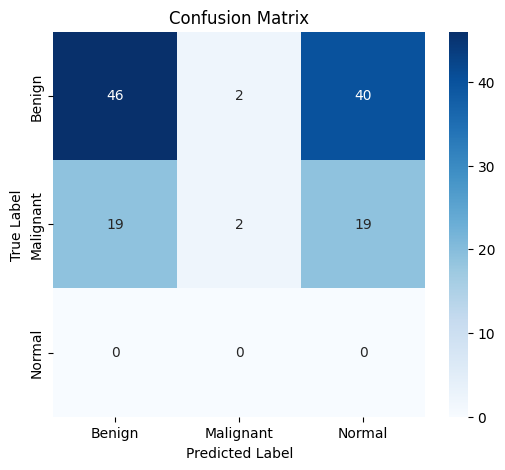

Shape of y_true_bin: (128, 3)


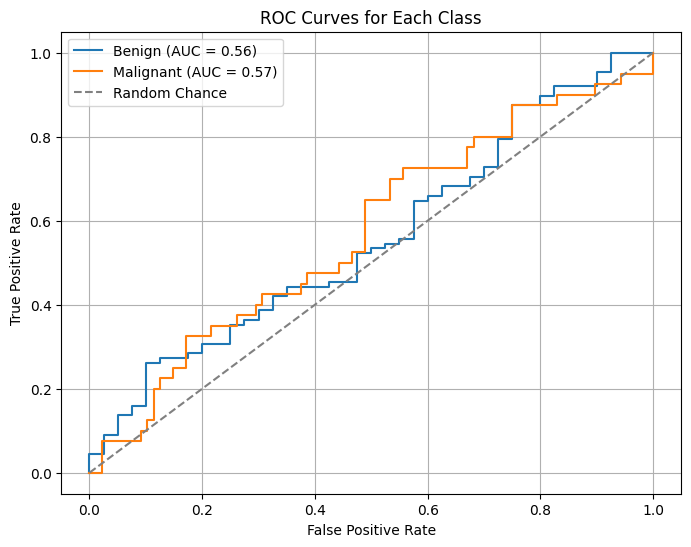

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize


y_true = [] 
y_pred = []  

classifier_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        predicted = outputs.softmax(dim=1).argmax(dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
labels = ["Benign", "Malignant", "Normal"]  

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


num_classes = len(set(y_true)) 
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

print("Shape of y_true_bin:", y_true_bin.shape) 

y_pred_prob = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = classifier_model(images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
        y_pred_prob.extend(probabilities)

y_pred_prob = np.array(y_pred_prob)  


if y_true_bin.shape[1] == 1:  
    from tensorflow.keras.utils import to_categorical
    y_true_bin = to_categorical(y_true, num_classes=num_classes)

plt.figure(figsize=(8, 6))

for i, label in enumerate(["Benign", "Malignant", "Normal"]):
    if np.sum(y_true_bin[:, i]) == 0:  
        continue

    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.grid(True)
plt.show()


y_true_bin shape: (128, 3)
y_pred_prob shape: (128, 3)
Unique y_true values: [0 1]


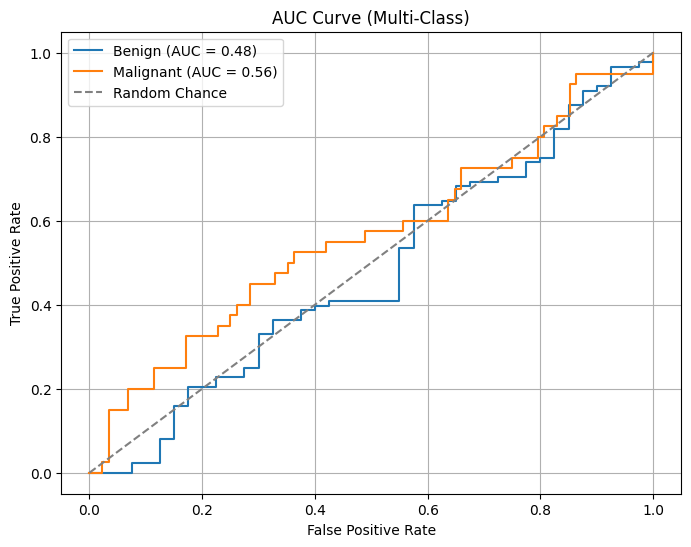

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_prob = []

classifier_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = classifier_model(images)
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.cpu().numpy())
        y_pred_prob.extend(probabilities)

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

class_labels = ["Benign", "Malignant", "Normal"]
num_classes = len(class_labels)


y_true_bin = label_binarize(y_true, classes=range(num_classes))

print("y_true_bin shape:", y_true_bin.shape)  
print("y_pred_prob shape:", y_pred_prob.shape)  
print("Unique y_true values:", np.unique(y_true))  
plt.figure(figsize=(8, 6))

for i, label in enumerate(class_labels):
    if np.sum(y_true_bin[:, i]) == 0:  
        continue  

    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC Curve (Multi-Class)")
plt.legend()
plt.grid(True)
plt.show()
